# 🎸 EDA – FINN Gitar Listings

Exploratory data analysis of guitar listings scraped from FINN.no.

**Ultimate goal:** identify and engineer features that are predictive of the **listed price**.

**Roadmap:**
1. Data overview & quality
2. Target variable (price) — distribution, log-transform, outliers, modelling scope
3. Seller type (private vs retailer)
4. **Feature engineering from titles** — item category, brand, condition
5. Geographic signal
6. Listing metadata (images, shipping, buy-now, age)
7. Correlation & feature importance → final feature shortlist

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import os

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
pd.set_option("display.max_columns", None)

os.chdir(os.path.join(os.path.dirname(os.path.abspath(".")), ""))
# Ensure we're in the project root
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

df = pd.read_csv("data/raw/gitar_listings_260219.csv")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
df.head(3)

Shape: 8,050 rows × 45 columns


,type,id,main_search_key,heading,location,flags,timestamp,ad_type,canonical_url,distance,trade_type,image_urls,ad_id,is_promoted,image_url,image_path,image_height,image_width,image_aspect_ratio,coordinates_lat,coordinates_lon,coordinates_accuracy,price_amount,price_currency_code,price_price_unit,brand,organisation_name,extra_brand,label_ids,label_texts,is_private,is_retailer,has_shipping,has_buy_now,num_images,timestamp_dt,page_current,page_last,total_match_count,total_group_count,search_query,fashion_hub_collections,extra_clothing_size,consoles_type,extra_consoles_type
0,bap,451514767,SEARCH_ID_BAP_ALL,LTD 87’ Eclipse,Oslo,"private, shipping_exists, buy_now",1771336237445,67,https://www.finn.no/recommerce/forsale/item/45...,0,Til salgs,['https://images.finncdn.no/dynamic/default/it...,451514767,True,https://images.finncdn.no/dynamic/default/item...,item/451514767/a9b6ab0d-6d4f-41cb-89e3-96153fd...,4032.0,3024.0,0.750000,59.91260,10.77691,5,10500,NOK,kr,NaN,NaN,NaN,"fiks_ferdig, buy_now, private","Fiks ferdig, Kjøp nå, Privat",True,False,True,True,2,2026-02-17 13:50:37.445000+00:00,1,50,8050,8050,gitar,NaN,NaN,NaN,NaN
1,bap,450523928,SEARCH_ID_BAP_ALL,Klassisk gitar CD-album,Oslo,private,1770753675000,67,https://www.finn.no/recommerce/forsale/item/45...,0,Gis bort,['https://images.finncdn.no/dynamic/default/it...,450523928,False,https://images.finncdn.no/dynamic/default/item...,item/450523928/8c14bc94-df26-4500-afff-a198dbb...,3024.0,4032.0,1.333333,59.91740,10.81920,5,0,NOK,kr,NaN,NaN,NaN,private,Privat,True,False,False,False,4,2026-02-10 20:01:15+00:00,1,50,8050,8050,gitar,NaN,NaN,NaN,NaN
2,bap,450063721,SEARCH_ID_BAP_ALL,Phil Capone Lær deg å spille gitar lærebok med CD,Fyllingsdalen,private,1770534699000,67,https://www.finn.no/recommerce/forsale/item/45...,0,Gis bort,['https://images.finncdn.no/dynamic/default/it...,450063721,False,https://images.finncdn.no/dynamic/default/item...,item/450063721/a75f901f-e1cf-4d41-8227-94395ba...,4032.0,3024.0,0.750000,60.34225,5.28754,5,0,NOK,kr,NaN,NaN,NaN,private,Privat,True,False,False,False,3,2026-02-08 07:11:39+00:00,1,50,8050,8050,gitar,NaN,NaN,NaN,NaN


## 1 — Data Overview & Quality

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8050 entries, 0 to 8049
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type                     8050 non-null   object 
 1   id                       8050 non-null   int64  
 2   main_search_key          8050 non-null   object 
 3   heading                  8050 non-null   object 
 4   location                 8050 non-null   object 
 5   flags                    8050 non-null   object 
 6   timestamp                8050 non-null   int64  
 7   ad_type                  8050 non-null   int64  
 8   canonical_url            8050 non-null   object 
 9   distance                 8050 non-null   int64  
 10  trade_type               8050 non-null   object 
 11  image_urls               8050 non-null   object 
 12  ad_id                    8050 non-null   int64  
 13  is_promoted              8050 non-null   bool   
 14  image_url               

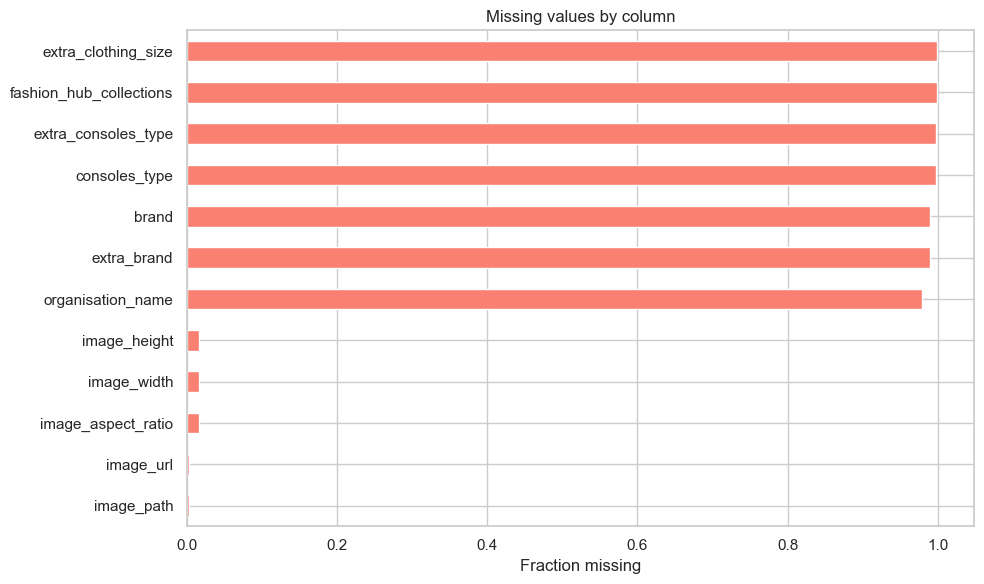


Columns with no missing values: 33
Columns with >50% missing: 7

Duplicate rows (by ad_id): 0


In [3]:
# Missing values heatmap
missing = df.isnull().mean().sort_values(ascending=False)
missing_pct = missing[missing > 0]

fig, ax = plt.subplots(figsize=(10, 6))
missing_pct.plot.barh(ax=ax, color="salmon")
ax.set_xlabel("Fraction missing")
ax.set_title("Missing values by column")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nColumns with no missing values: {(missing == 0).sum()}")
print(f"Columns with >50% missing: {(missing > 0.5).sum()}")
print(f"\nDuplicate rows (by ad_id): {df.duplicated(subset='ad_id').sum()}")

In [4]:
# Descriptive statistics for numeric columns
df.describe().round(2)

,id,timestamp,ad_type,distance,ad_id,image_height,image_width,image_aspect_ratio,coordinates_lat,coordinates_lon,coordinates_accuracy,price_amount,num_images,page_current,page_last,total_match_count,total_group_count
count,8.050000e+03,8.050000e+03,8050.00,8050.0,8.050000e+03,7913.00,7913.00,7913.00,8050.00,8050.00,8050.00,8050.00,8050.00,8050.00,8050.00,8050.00,8050.00
mean,4.094680e+08,1.769349e+12,67.02,0.0,4.094680e+08,2768.41,2642.52,1.02,60.17,9.51,5.03,5275.20,4.62,25.22,48.61,5349.69,5349.69
std,7.066604e+07,1.521681e+09,0.15,0.0,7.066604e+07,1398.99,1340.05,0.38,4.80,2.95,0.59,11994.59,2.99,14.51,7.79,2254.36,2254.36
min,2.227784e+07,1.735992e+12,67.00,0.0,2.227784e+07,-1.00,-1.00,0.28,0.00,0.00,0.00,0.00,0.00,1.00,5.00,259.00,259.00
25%,4.030661e+08,1.768143e+12,67.00,0.0,4.030661e+08,1600.00,1368.00,0.75,59.38,7.63,5.00,200.00,2.00,12.25,50.00,2904.00,2904.00
50%,4.409511e+08,1.769509e+12,67.00,0.0,4.409511e+08,3024.00,3000.00,0.98,59.92,10.41,5.00,1085.00,4.00,25.00,50.00,5422.00,5422.00
75%,4.485994e+08,1.770658e+12,67.00,0.0,4.485994e+08,4000.00,4000.00,1.33,60.43,10.80,5.00,4500.00,7.00,38.00,50.00,8050.00,8050.00
max,4.518598e+08,1.771534e+12,68.00,0.0,4.518598e+08,10008.00,9248.00,5.49,70.98,31.11,9.00,250000.00,10.00,50.00,50.00,8050.00,8050.00


## 2 — Target Variable: Price

Before engineering features we need to understand the target and define the modelling scope:
- Which rows should we **exclude** (free items, want-to-buy ads, extreme outliers)?
- Should we model raw price or **log(price)**?

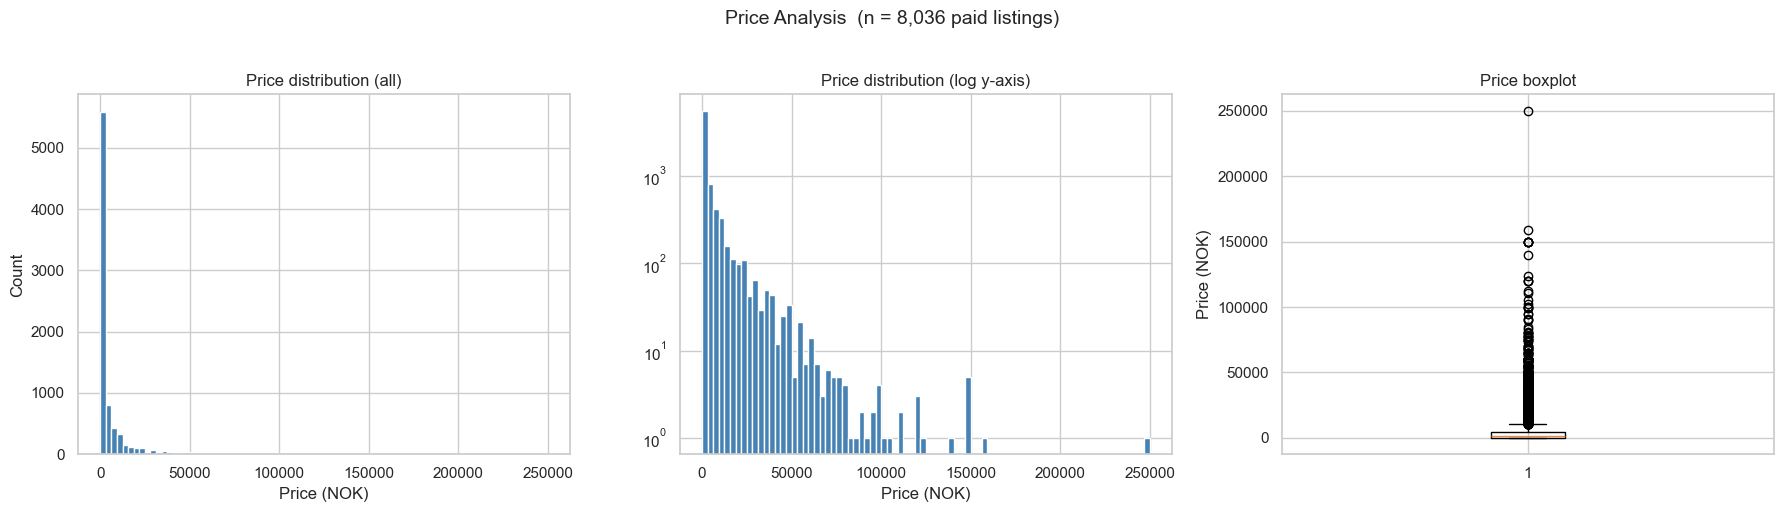

Median price: 1,100 NOK
Mean price:   5,284 NOK
Free items (price=0): 14
95th percentile: 25,125 NOK
99th percentile: 55,000 NOK
Max price: 250,000 NOK


In [5]:
# Filter to listings with a price > 0 (remove "Gis bort" / free items)
prices = df.loc[df["price_amount"] > 0, "price_amount"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Full distribution
axes[0].hist(prices, bins=80, color="steelblue", edgecolor="white")
axes[0].set_title("Price distribution (all)")
axes[0].set_xlabel("Price (NOK)")
axes[0].set_ylabel("Count")

# Log-scale histogram
axes[1].hist(prices, bins=80, color="steelblue", edgecolor="white", log=True)
axes[1].set_title("Price distribution (log y-axis)")
axes[1].set_xlabel("Price (NOK)")

# Boxplot
axes[2].boxplot(prices, vert=True)
axes[2].set_title("Price boxplot")
axes[2].set_ylabel("Price (NOK)")

plt.suptitle(f"Price Analysis  (n = {len(prices):,} paid listings)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"Median price: {prices.median():,.0f} NOK")
print(f"Mean price:   {prices.mean():,.0f} NOK")
print(f"Free items (price=0): {(df['price_amount'] == 0).sum():,}")
print(f"95th percentile: {prices.quantile(0.95):,.0f} NOK")
print(f"99th percentile: {prices.quantile(0.99):,.0f} NOK")
print(f"Max price: {prices.max():,.0f} NOK")

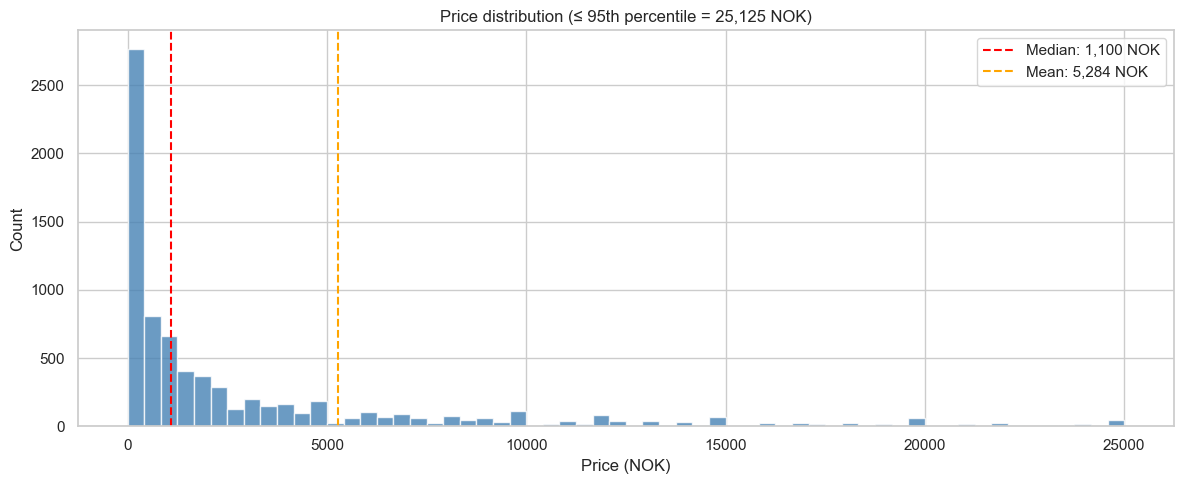

In [6]:
# Price distribution zoomed to reasonable range (< 95th percentile)
p95 = prices.quantile(0.95)
zoomed = prices[prices <= p95]

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(zoomed, bins=60, color="steelblue", edgecolor="white", alpha=0.8)
ax.axvline(prices.median(), color="red", linestyle="--", label=f"Median: {prices.median():,.0f} NOK")
ax.axvline(prices.mean(), color="orange", linestyle="--", label=f"Mean: {prices.mean():,.0f} NOK")
ax.set_xlabel("Price (NOK)")
ax.set_ylabel("Count")
ax.set_title(f"Price distribution (≤ 95th percentile = {p95:,.0f} NOK)")
ax.legend()
plt.tight_layout()
plt.show()

Trade types:
trade_type
Til salgs       7863
Ønskes kjøpt     176
Gis bort          11

Rows to exclude (trade_type ≠ 'Til salgs'): 187
Rows to exclude (price ≤ 0):                14

→ Modelling subset: 7,863 listings


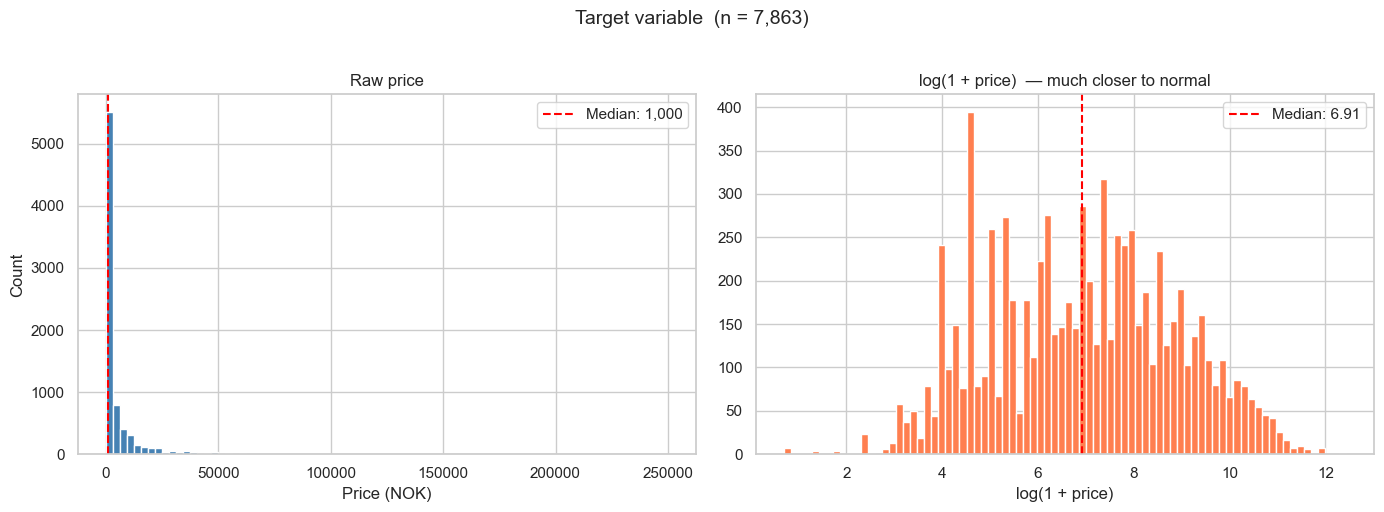

Raw price  — skew: 5.86,  kurtosis: 57.68
Log price  — skew: 0.01,  kurtosis: -0.71

→ log(price) is far less skewed → better target for regression.


In [7]:
# ---- Modelling scope: what to keep / exclude ----
print("Trade types:")
print(df["trade_type"].value_counts().to_string())
print()

# "Ønskes kjøpt" = want-to-buy ads (price = what buyer is willing to pay, not a sale price)
# "Gis bort"     = free giveaways (price = 0)
# → keep only "Til salgs"
exclude_trade = df["trade_type"] != "Til salgs"
exclude_free  = df["price_amount"] <= 0
print(f"Rows to exclude (trade_type ≠ 'Til salgs'): {exclude_trade.sum():,}")
print(f"Rows to exclude (price ≤ 0):                {exclude_free.sum():,}")

# Work with the modelling subset from here on
model_df = df[(df["trade_type"] == "Til salgs") & (df["price_amount"] > 0)].copy()
print(f"\n→ Modelling subset: {len(model_df):,} listings")

# Log-transform the target
model_df["log_price"] = np.log1p(model_df["price_amount"])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(model_df["price_amount"], bins=80, color="steelblue", edgecolor="white")
axes[0].axvline(model_df["price_amount"].median(), color="red", ls="--",
                label=f"Median: {model_df['price_amount'].median():,.0f}")
axes[0].set_title("Raw price")
axes[0].set_xlabel("Price (NOK)")
axes[0].set_ylabel("Count")
axes[0].legend()

axes[1].hist(model_df["log_price"], bins=80, color="coral", edgecolor="white")
axes[1].axvline(model_df["log_price"].median(), color="red", ls="--",
                label=f"Median: {model_df['log_price'].median():.2f}")
axes[1].set_title("log(1 + price)  — much closer to normal")
axes[1].set_xlabel("log(1 + price)")
axes[1].legend()

plt.suptitle(f"Target variable  (n = {len(model_df):,})", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

from scipy.stats import skew, kurtosis
print(f"Raw price  — skew: {skew(model_df['price_amount']):.2f},  kurtosis: {kurtosis(model_df['price_amount']):.2f}")
print(f"Log price  — skew: {skew(model_df['log_price']):.2f},  kurtosis: {kurtosis(model_df['log_price']):.2f}")
print("\n→ log(price) is far less skewed → better target for regression.")

In [8]:
# Outlier analysis using IQR on log_price
Q1, Q3 = model_df["log_price"].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = model_df[(model_df["log_price"] < lower) | (model_df["log_price"] > upper)]
print(f"IQR outliers in log-space: {len(outliers):,} ({len(outliers)/len(model_df)*100:.1f}%)")
print(f"  Lower bound: {np.expm1(lower):,.0f} NOK")
print(f"  Upper bound: {np.expm1(upper):,.0f} NOK")

# Show price percentiles to inform a sensible cap
pcts = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("\nPrice percentiles:")
for p in pcts:
    v = model_df["price_amount"].quantile(p/100)
    print(f"  {p:>3}%  →  {v:>10,.0f} NOK")

# Histogram of most expensive listings
print(f"\nTop 10 most expensive:")
print(model_df.nlargest(10, "price_amount")[["heading", "price_amount", "location", "is_retailer"]].to_string(index=False))

IQR outliers in log-space: 0 (0.0%)
  Lower bound: 1 NOK
  Upper bound: 476,955 NOK

Price percentiles:
    1%  →          20 NOK
    5%  →          50 NOK
   10%  →          75 NOK
   25%  →         200 NOK
   50%  →       1,000 NOK
   75%  →       4,500 NOK
   90%  →      14,000 NOK
   95%  →      25,000 NOK
   99%  →      55,000 NOK

Top 10 most expensive:
                                                                heading  price_amount       location  is_retailer
                                            Martin Custom gitar selges.        250000           Oslo        False
                                                    Martin D18 fra 1946        159000      Arnatveit        False
                                           Martin OM-45 gitar til salgs        150000           Oslo        False
                                     Stelling gitar, Brazilian Rosewood        150000      Arnatveit        False
                                       Marshall JVM 410C 100W 4-kana

## 3 — Seller Analysis (Private vs Retailer)

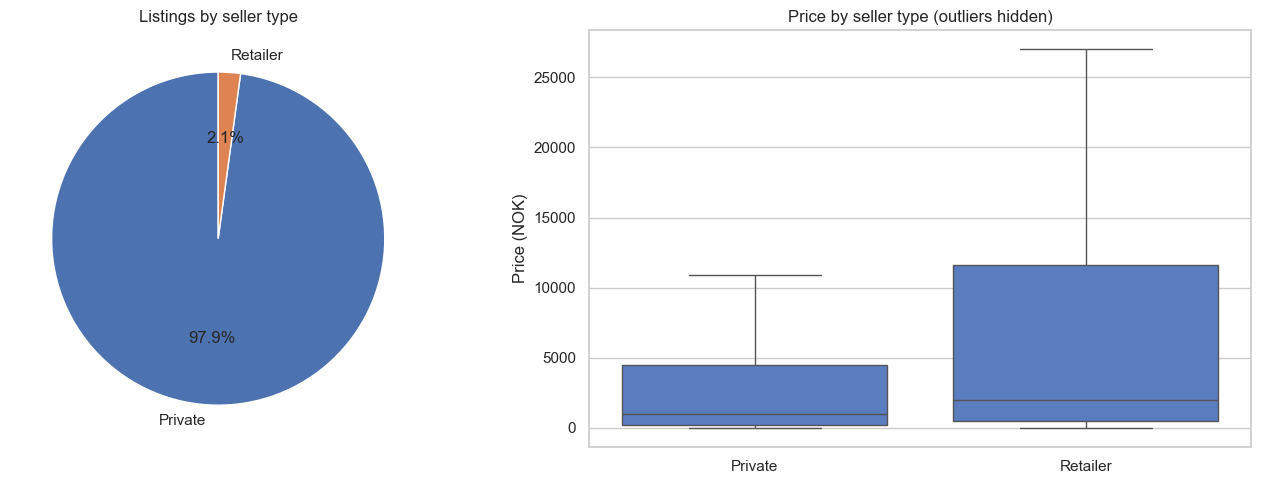

Price stats by seller type:
             count  median    mean  min     max
is_retailer                                    
Private       7690  1000.0  5096.0    1  250000
Retailer       173  1995.0  9543.0    3   80900


In [9]:
# Private vs retailer breakdown
seller_type = df["is_retailer"].map({True: "Retailer", False: "Private"})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count
seller_counts = seller_type.value_counts()
axes[0].pie(seller_counts, labels=seller_counts.index, autopct="%1.1f%%",
            colors=["#4c72b0", "#dd8452"], startangle=90)
axes[0].set_title("Listings by seller type")

# Price comparison
sns.boxplot(data=model_df.assign(seller=model_df["is_retailer"].map({True: "Retailer", False: "Private"})),
            x="seller", y="price_amount", ax=axes[1], showfliers=False)
axes[1].set_title("Price by seller type (outliers hidden)")
axes[1].set_ylabel("Price (NOK)")
axes[1].set_xlabel("")

plt.tight_layout()
plt.show()

# Summary stats
print("Price stats by seller type:")
print(model_df.groupby(model_df["is_retailer"].map({True: "Retailer", False: "Private"}))["price_amount"]
      .agg(["count", "median", "mean", "min", "max"]).round(0).to_string())

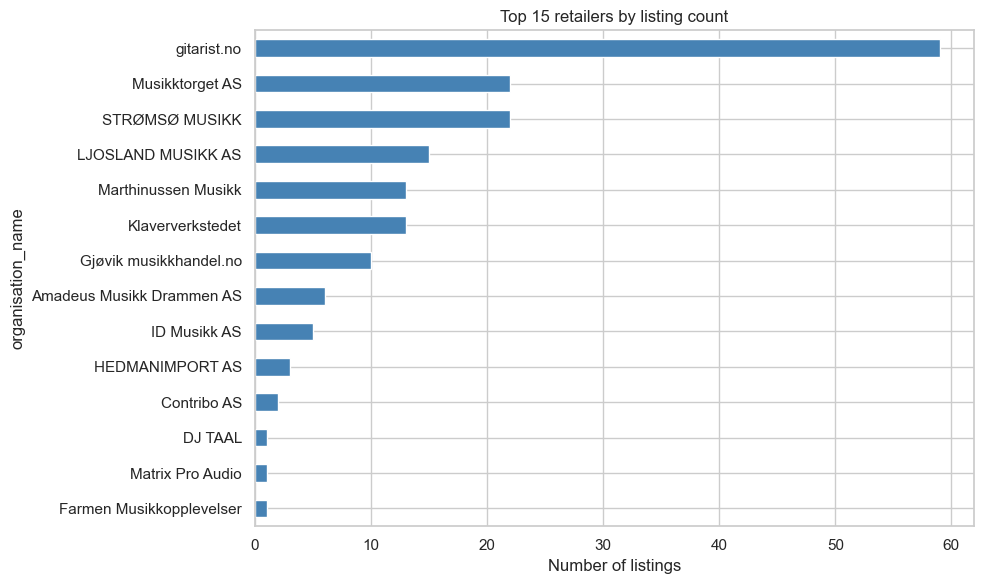

In [10]:
# Top retailers by number of listings
retailers = df[df["is_retailer"] == True]
if not retailers.empty and "organisation_name" in retailers.columns:
    top_retailers = retailers["organisation_name"].value_counts().head(15)
    fig, ax = plt.subplots(figsize=(10, 6))
    top_retailers.plot.barh(ax=ax, color="steelblue")
    ax.set_xlabel("Number of listings")
    ax.set_title("Top 15 retailers by listing count")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No retailer listings or organisation_name column not found.")

## 4 — Feature Engineering from Titles

The `extra_brand` column is only populated for **1.1%** of listings — useless as a direct feature.
But the **title (`heading`)** is rich with information. We can extract:

1. **Item category** — is this a guitar, an amplifier, a pedal, strings, a case, a book, …?
2. **Brand** — Fender, Gibson, Yamaha, Ibanez, etc.  (keyword matching on title)
3. **Condition hints** — "ny" (new), "brukt" (used), "god stand" (good condition), "defekt" (broken)

These are likely the **strongest predictive features** in the dataset.

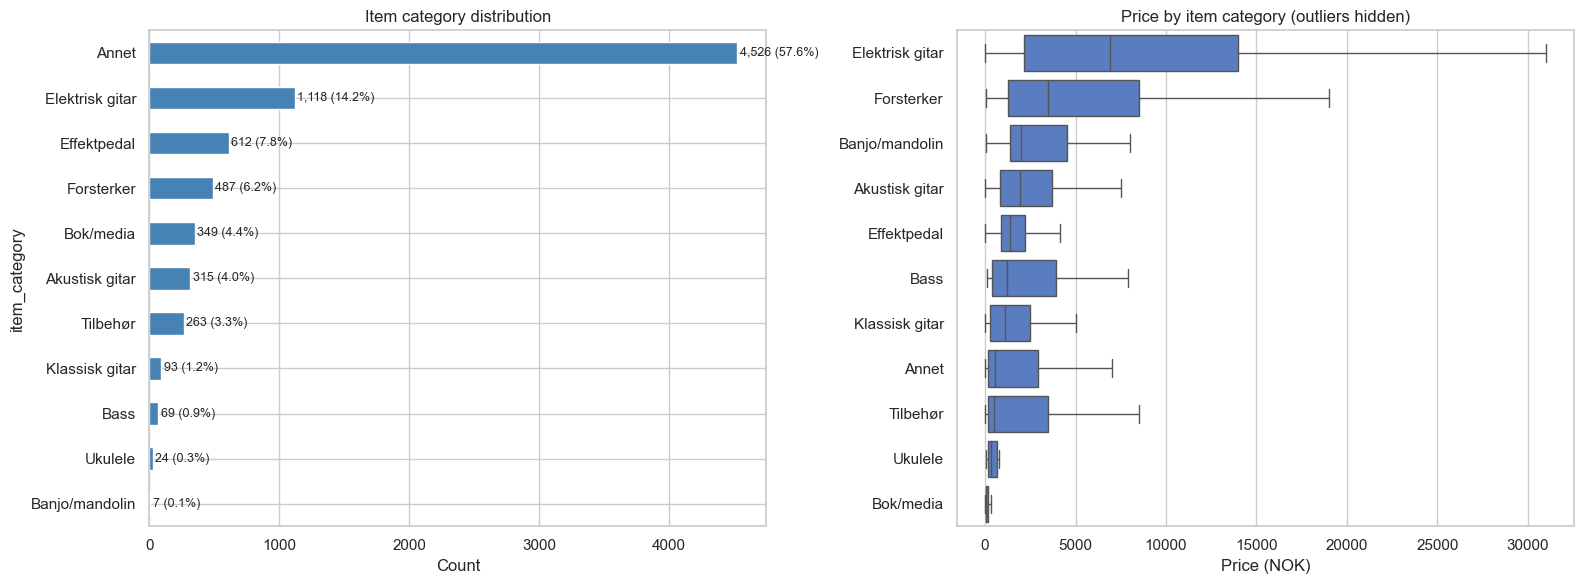


Median price by category:
  Elektrisk gitar       n=1,118  median=   6,900 NOK
  Forsterker            n=  487  median=   3,500 NOK
  Banjo/mandolin        n=    7  median=   2,000 NOK
  Akustisk gitar        n=  315  median=   1,950 NOK
  Effektpedal           n=  612  median=   1,400 NOK
  Bass                  n=   69  median=   1,200 NOK
  Klassisk gitar        n=   93  median=   1,095 NOK
  Annet                 n=4,526  median=     550 NOK
  Tilbehør              n=  263  median=     500 NOK
  Ukulele               n=   24  median=     300 NOK
  Bok/media             n=  349  median=      70 NOK


In [11]:
# ---- 4a. Item category extraction from title ----
# The search "gitar" returns guitars but also amps, pedals, accessories, books, etc.
# These have vastly different price ranges, so category is a key feature.

CATEGORY_PATTERNS = {
    "Elektrisk gitar":   r"\b(electric|elektrisk|strat|stratocaster|telecaster|les\s*paul|sg\b|flying\s*v|explorer|jazzmaster|jaguar|offset|superstrat|soloist|dinky|jackson|esp|ltd|prs|epiphone)\b",
    "Akustisk gitar":    r"\b(akustisk|acoustic|western|dreadnought|jumbo|parlor|fingerstyle|folk\s*gitar|steel\s*string)\b",
    "Klassisk gitar":    r"\b(klassisk|classical|nylon|spansk|flamenco)\b",
    "Bass":              r"\b(bass|precision|jazz\s*bass|p-bass|j-bass)\b",
    "Forsterker":        r"\b(amp|amps|amplifier|forsterker|combo|rørforsterker|tube\s*amp|head\b|cabinet|cab\b|stack|marshall|fender\s*(twin|deluxe|blues|hot\s*rod|champion|mustang)|vox|orange|mesa|boogie|peavey|blackstar|boss\s*katana|katana|roland)\b",
    "Effektpedal":       r"\b(pedal|pedaler|pedalboard|overdrive|distortion|fuzz|delay|reverb|chorus|phaser|flanger|wah|looper|tuner\s*pedal|strymon|tc\s*electronic|boss\b|mxr|electro.harmonix|ehx)\b",
    "Tilbehør":          r"\b(strenger|strings|capo|picks|plekter|stemmers|tuner|strap|reim|kabel|jack|stand|stativ|veske|bag|case|koffert|gigbag|hard\s*case)\b",
    "Bok/media":         r"\b(bok|bøker|book|lærebok|noter|tabs|tab\s*book|dvd|cd|lær\s*deg|learn|course|kurs)\b",
    "Ukulele":           r"\b(ukulele|uke)\b",
    "Banjo/mandolin":    r"\b(banjo|mandolin)\b",
}

title_lower = model_df["heading"].str.lower()

for cat, pattern in CATEGORY_PATTERNS.items():
    model_df[f"_cat_{cat}"] = title_lower.str.contains(pattern, regex=True, na=False)

# Assign primary category (first match wins, ordered by specificity)
cat_cols = [f"_cat_{c}" for c in CATEGORY_PATTERNS]

def assign_category(row):
    for cat_name, col in zip(CATEGORY_PATTERNS.keys(), cat_cols):
        if row[col]:
            return cat_name
    return "Annet"

model_df["item_category"] = model_df.apply(assign_category, axis=1)

# Drop helper columns
model_df.drop(columns=cat_cols, inplace=True)

# Show distribution
cat_counts = model_df["item_category"].value_counts()
cat_median_price = model_df.groupby("item_category")["price_amount"].median().reindex(cat_counts.index)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cat_counts.plot.barh(ax=axes[0], color="steelblue")
axes[0].set_xlabel("Count")
axes[0].set_title("Item category distribution")
axes[0].invert_yaxis()
for i, (v, cat) in enumerate(zip(cat_counts.values, cat_counts.index)):
    axes[0].text(v + 20, i, f"{v:,} ({v/len(model_df)*100:.1f}%)", va="center", fontsize=9)

order = model_df.groupby("item_category")["price_amount"].median().sort_values(ascending=False).index
sns.boxplot(data=model_df, y="item_category", x="price_amount", order=order,
            ax=axes[1], showfliers=False)
axes[1].set_title("Price by item category (outliers hidden)")
axes[1].set_xlabel("Price (NOK)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

print("\nMedian price by category:")
for cat in order:
    n = (model_df["item_category"] == cat).sum()
    med = model_df.loc[model_df["item_category"] == cat, "price_amount"].median()
    print(f"  {cat:<20s}  n={n:>5,}  median={med:>8,.0f} NOK")

Listings with detected brand: 2,456 / 7,863 (31.2%)
Unique brands found: 46



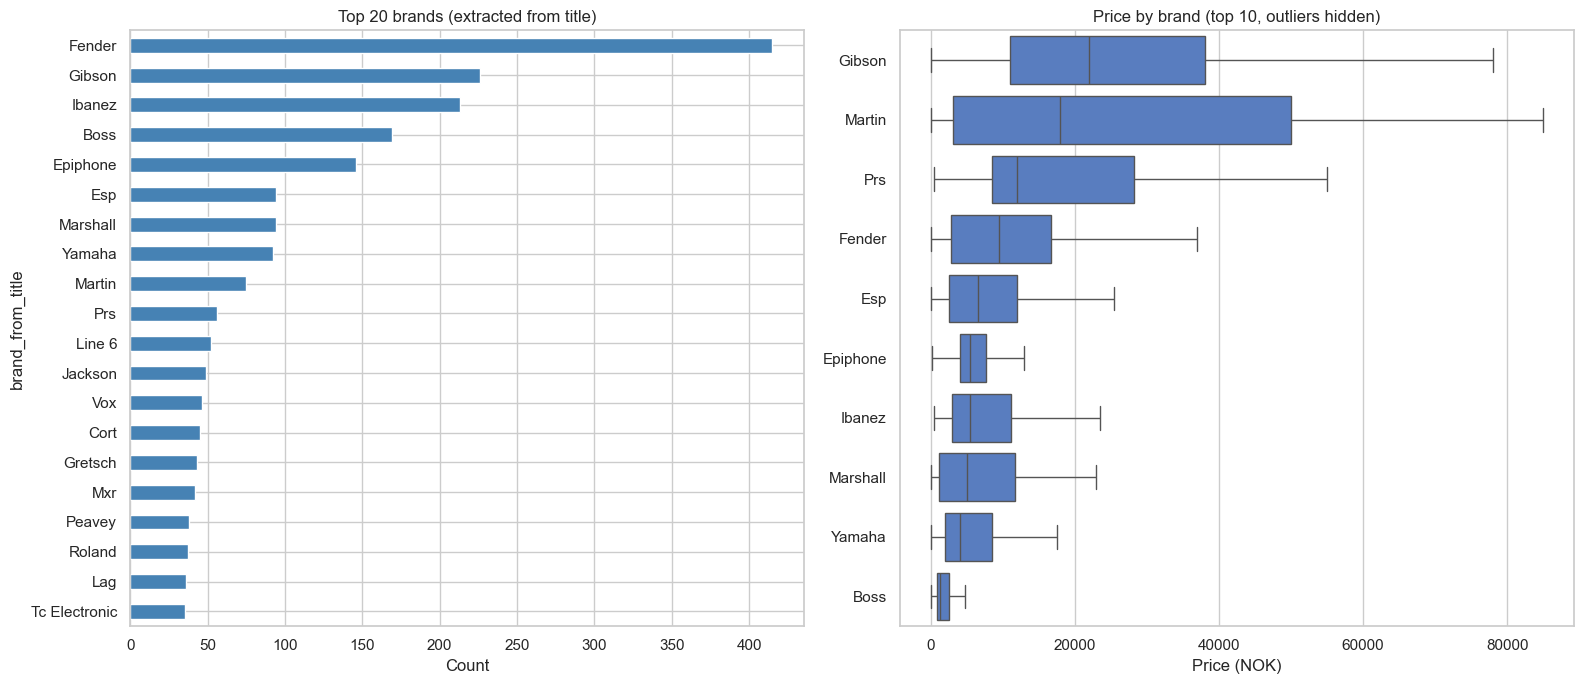

Median price by brand (top 10):
  Gibson                n= 226  median=  22,000 NOK
  Martin                n=  75  median=  18,000 NOK
  Prs                   n=  56  median=  12,000 NOK
  Fender                n= 415  median=   9,500 NOK
  Esp                   n=  94  median=   6,500 NOK
  Epiphone              n= 146  median=   5,500 NOK
  Ibanez                n= 213  median=   5,500 NOK
  Marshall              n=  94  median=   5,000 NOK
  Yamaha                n=  92  median=   4,000 NOK
  Boss                  n= 169  median=   1,300 NOK


In [12]:
# ---- 4b. Brand extraction from title ----
BRANDS = [
    "fender", "gibson", "yamaha", "ibanez", "epiphone", "taylor", "martin",
    "prs", "esp", "ltd", "jackson", "schecter", "squier", "gretsch",
    "rickenbacker", "dean", "cort", "takamine", "ovation", "guild",
    "marshall", "vox", "orange", "mesa", "peavey", "blackstar", "boss",
    "tc electronic", "strymon", "mxr", "electro-harmonix", "ehx",
    "line 6", "behringer", "roland", "korg", "zoom", "digitech",
    "seymour duncan", "dimarzio", "emg",
    "harley benton", "lag", "godin", "córdoba", "cordoba", "alhambra",
]

title_lower = model_df["heading"].str.lower()

def extract_brand(title):
    for brand in BRANDS:
        if brand in title:
            return brand.title()
    return "Unknown"

model_df["brand_from_title"] = title_lower.apply(extract_brand)

brand_counts = model_df["brand_from_title"].value_counts()
known = brand_counts.drop("Unknown", errors="ignore")

print(f"Listings with detected brand: {(model_df['brand_from_title'] != 'Unknown').sum():,} / {len(model_df):,} "
      f"({(model_df['brand_from_title'] != 'Unknown').mean()*100:.1f}%)")
print(f"Unique brands found: {len(known)}\n")

# Top 20 brands
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

known.head(20).plot.barh(ax=axes[0], color="steelblue")
axes[0].set_xlabel("Count")
axes[0].set_title("Top 20 brands (extracted from title)")
axes[0].invert_yaxis()

# Price by top-10 brands
top10 = known.head(10).index
brand_df = model_df[model_df["brand_from_title"].isin(top10)]
order = brand_df.groupby("brand_from_title")["price_amount"].median().sort_values(ascending=False).index
sns.boxplot(data=brand_df, y="brand_from_title", x="price_amount", order=order,
            ax=axes[1], showfliers=False)
axes[1].set_title("Price by brand (top 10, outliers hidden)")
axes[1].set_xlabel("Price (NOK)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

print("Median price by brand (top 10):")
for b in order:
    n = (model_df["brand_from_title"] == b).sum()
    med = model_df.loc[model_df["brand_from_title"] == b, "price_amount"].median()
    print(f"  {b:<20s}  n={n:>4,}  median={med:>8,.0f} NOK")

## 5 — Geographic Signal

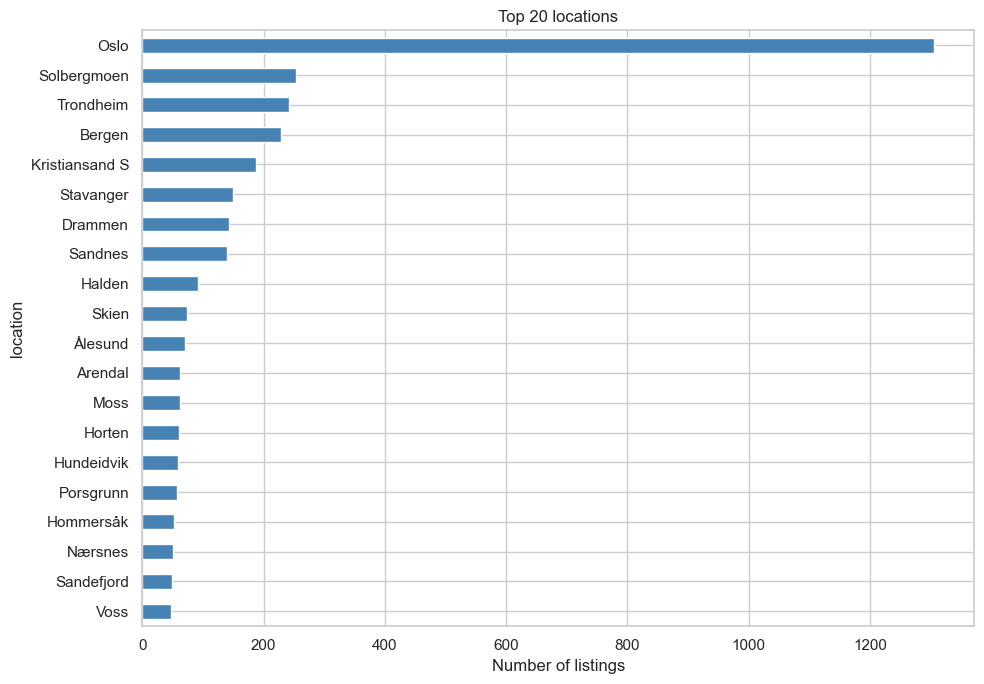

In [13]:
# Top 20 locations
top_locations = df["location"].value_counts().head(20)

fig, ax = plt.subplots(figsize=(10, 7))
top_locations.plot.barh(ax=ax, color="steelblue")
ax.set_xlabel("Number of listings")
ax.set_title("Top 20 locations")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [14]:
# Interactive map of listings (sample if too many points)
geo = df.dropna(subset=["coordinates_lat", "coordinates_lon"]).copy()
if len(geo) > 2000:
    geo = geo.sample(2000, random_state=42)

geo["price_label"] = geo["price_amount"].apply(lambda x: f"{x:,.0f} NOK")

fig = px.scatter_mapbox(
    geo,
    lat="coordinates_lat",
    lon="coordinates_lon",
    color="is_retailer",
    size="price_amount",
    size_max=15,
    hover_name="heading",
    hover_data=["price_label", "location", "trade_type"],
    mapbox_style="carto-positron",
    zoom=4,
    center={"lat": 63.0, "lon": 10.5},
    title="Guitar listings across Norway",
    height=600,
    color_discrete_map={True: "#dd8452", False: "#4c72b0"},
)
fig.update_layout(margin={"r": 0, "t": 40, "l": 0, "b": 0})
fig.show()

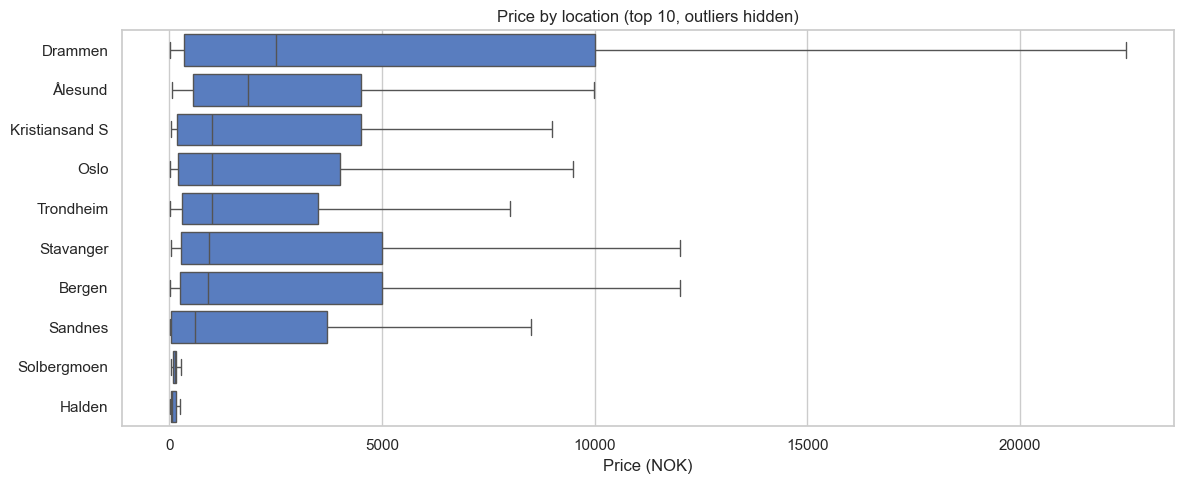

In [15]:
# Median price by top-10 locations
top_loc_names = model_df["location"].value_counts().head(10).index
loc_prices = model_df[model_df["location"].isin(top_loc_names)]

order = loc_prices.groupby("location")["price_amount"].median().sort_values(ascending=False).index

fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=loc_prices, y="location", x="price_amount", order=order,
            ax=ax, showfliers=False)
ax.set_title("Price by location (top 10, outliers hidden)")
ax.set_xlabel("Price (NOK)")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

## 6 — Listing Metadata (images, shipping, age)

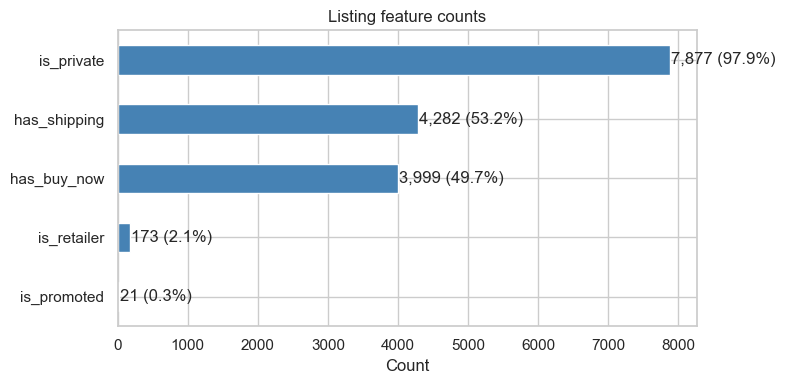

In [16]:
# Boolean feature breakdown
bool_cols = ["is_private", "is_retailer", "has_shipping", "has_buy_now", "is_promoted"]
bool_df = df[bool_cols].sum().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8, 4))
bool_df.plot.barh(ax=ax, color="steelblue")
ax.set_xlabel("Count")
ax.set_title("Listing feature counts")
for i, (val, name) in enumerate(zip(bool_df.values, bool_df.index)):
    ax.text(val + 20, i, f"{val:,} ({val/len(df)*100:.1f}%)", va="center")
plt.tight_layout()
plt.show()

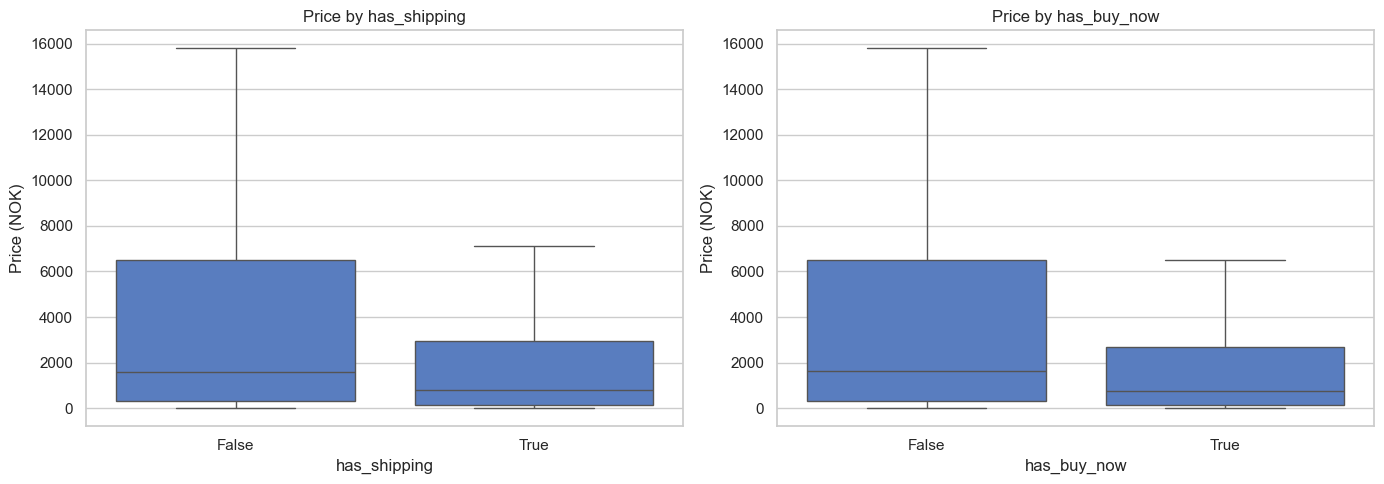


Median price by has_shipping:
  has_shipping=False: 1,600 NOK
  has_shipping=True: 800 NOK

Median price by has_buy_now:
  has_buy_now=False: 1,650 NOK
  has_buy_now=True: 750 NOK


In [17]:
# Impact of shipping / buy-now on price
features = ["has_shipping", "has_buy_now"]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, feat in zip(axes, features):
    sns.boxplot(data=model_df, x=feat, y="price_amount", ax=ax, showfliers=False)
    ax.set_title(f"Price by {feat}")
    ax.set_ylabel("Price (NOK)")

plt.tight_layout()
plt.show()

# Median prices
for feat in features:
    grp = model_df.groupby(feat)["price_amount"].median()
    print(f"\nMedian price by {feat}:")
    for k, v in grp.items():
        print(f"  {feat}={k}: {v:,.0f} NOK")

## 6b — Image count vs price

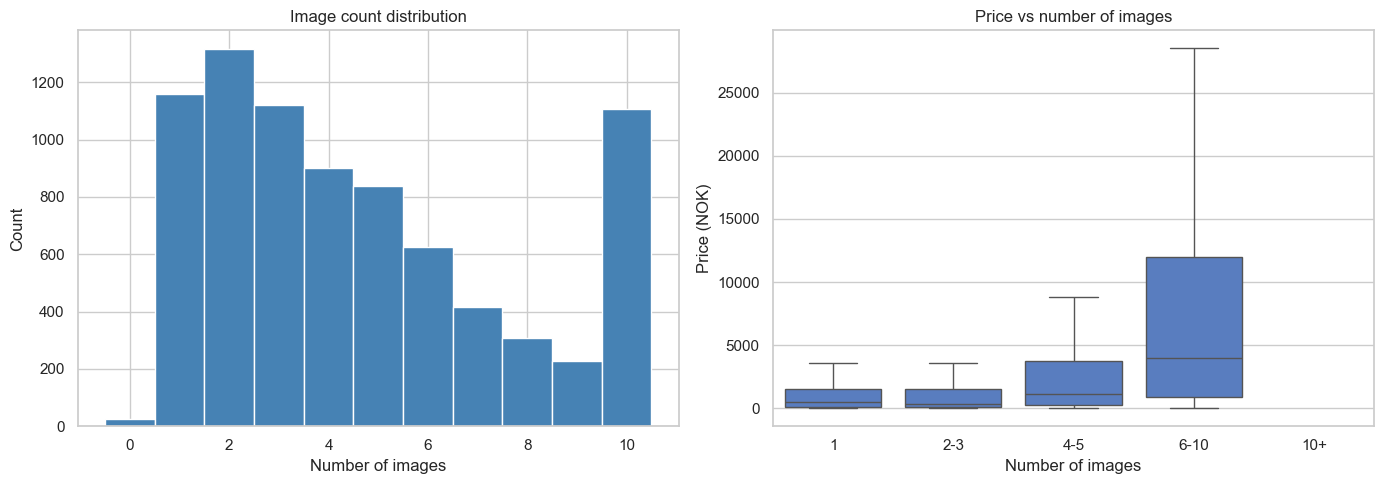

Average images per listing: 4.6
Listings with 0 images: 27


In [18]:
# Number of images per listing
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df["num_images"], bins=range(0, df["num_images"].max() + 2),
             color="steelblue", edgecolor="white", align="left")
axes[0].set_xlabel("Number of images")
axes[0].set_ylabel("Count")
axes[0].set_title("Image count distribution")

# Does more images correlate with price?
img_bins = pd.cut(model_df["num_images"], bins=[0, 1, 3, 5, 10, 100],
                  labels=["1", "2-3", "4-5", "6-10", "10+"], right=True)
sns.boxplot(data=model_df.assign(img_group=img_bins), x="img_group", y="price_amount",
            ax=axes[1], showfliers=False)
axes[1].set_xlabel("Number of images")
axes[1].set_ylabel("Price (NOK)")
axes[1].set_title("Price vs number of images")

plt.tight_layout()
plt.show()

print(f"Average images per listing: {df['num_images'].mean():.1f}")
print(f"Listings with 0 images: {(df['num_images'] == 0).sum()}")

## 8 — Temporal Patterns

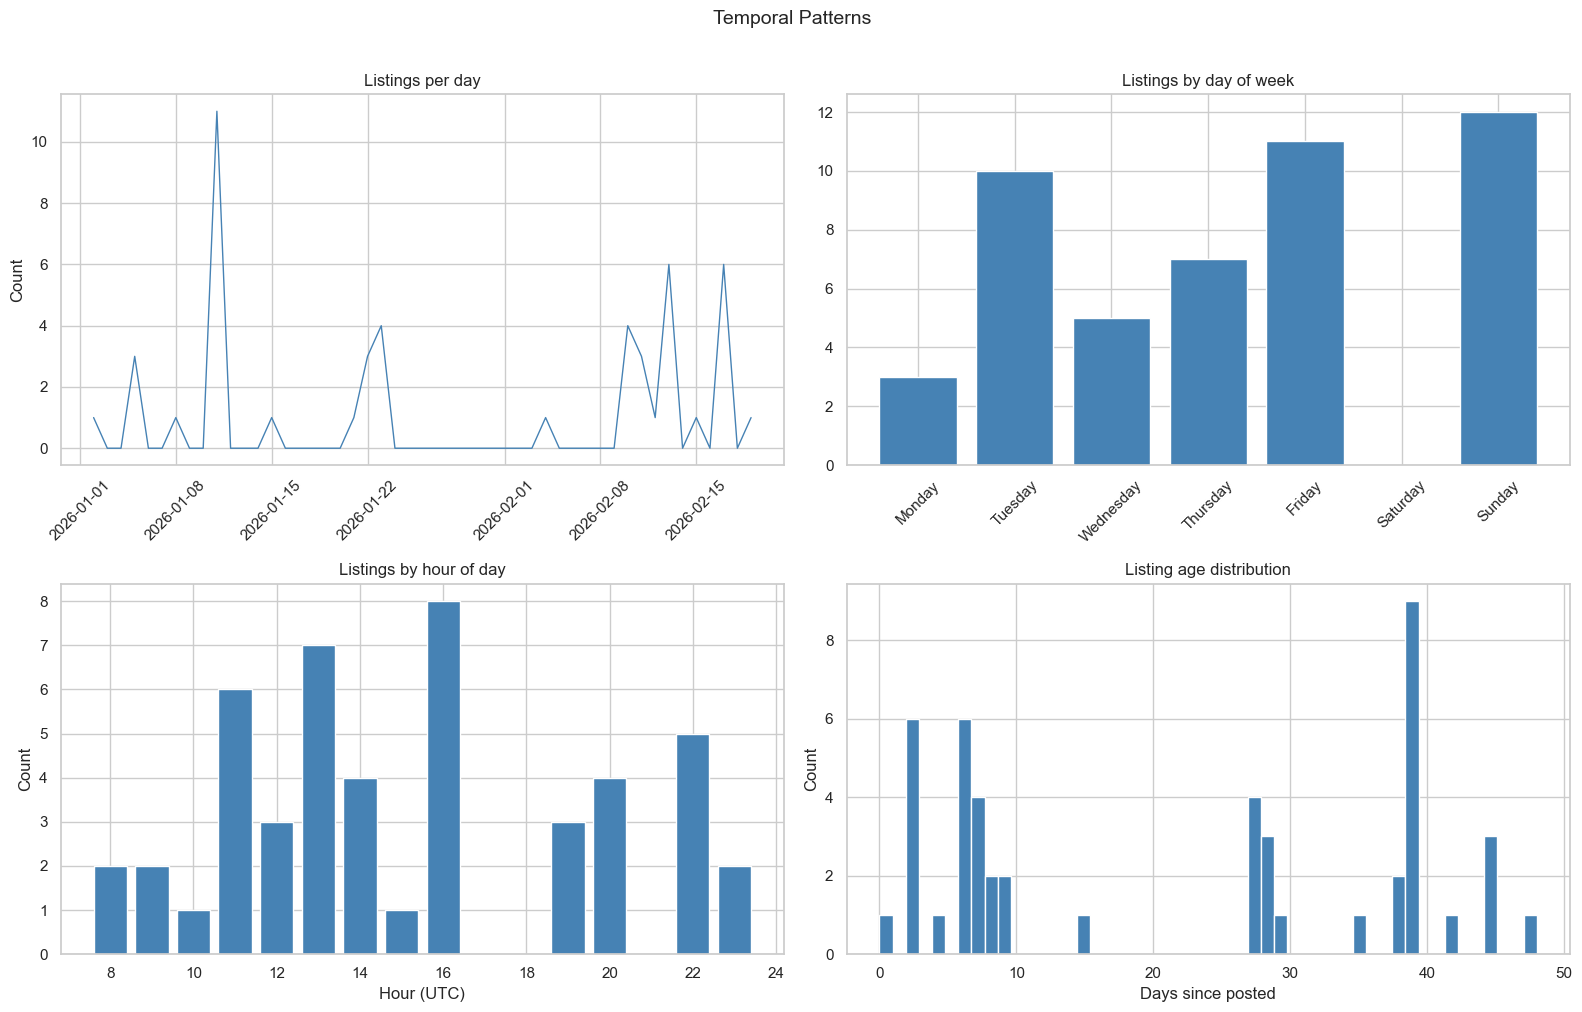

Oldest listing: 48 days
Newest listing: 0 days
Median listing age: 27 days


In [19]:
# Parse timestamps
df["timestamp_dt"] = pd.to_datetime(df["timestamp_dt"], utc=True, errors="coerce")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Listings over time (by day)
daily = df.set_index("timestamp_dt").resample("D").size()
axes[0, 0].plot(daily.index, daily.values, color="steelblue", linewidth=1)
axes[0, 0].set_title("Listings per day")
axes[0, 0].set_ylabel("Count")
axes[0, 0].tick_params(axis="x", rotation=45)

# By day of week
df["dow"] = df["timestamp_dt"].dt.day_name()
dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_counts = df["dow"].value_counts().reindex(dow_order)
axes[0, 1].bar(dow_counts.index, dow_counts.values, color="steelblue")
axes[0, 1].set_title("Listings by day of week")
axes[0, 1].tick_params(axis="x", rotation=45)

# By hour
df["hour"] = df["timestamp_dt"].dt.hour
hour_counts = df["hour"].value_counts().sort_index()
axes[1, 0].bar(hour_counts.index, hour_counts.values, color="steelblue")
axes[1, 0].set_title("Listings by hour of day")
axes[1, 0].set_xlabel("Hour (UTC)")
axes[1, 0].set_ylabel("Count")

# Age of listing (days since posted)
df["listing_age_days"] = (pd.Timestamp.now(tz="UTC") - df["timestamp_dt"]).dt.days
axes[1, 1].hist(df["listing_age_days"].dropna(), bins=50, color="steelblue", edgecolor="white")
axes[1, 1].set_title("Listing age distribution")
axes[1, 1].set_xlabel("Days since posted")
axes[1, 1].set_ylabel("Count")

plt.suptitle("Temporal Patterns", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

print(f"Oldest listing: {df['listing_age_days'].max():.0f} days")
print(f"Newest listing: {df['listing_age_days'].min():.0f} days")
print(f"Median listing age: {df['listing_age_days'].median():.0f} days")

## 7 — Condition & Quality Signals from Titles

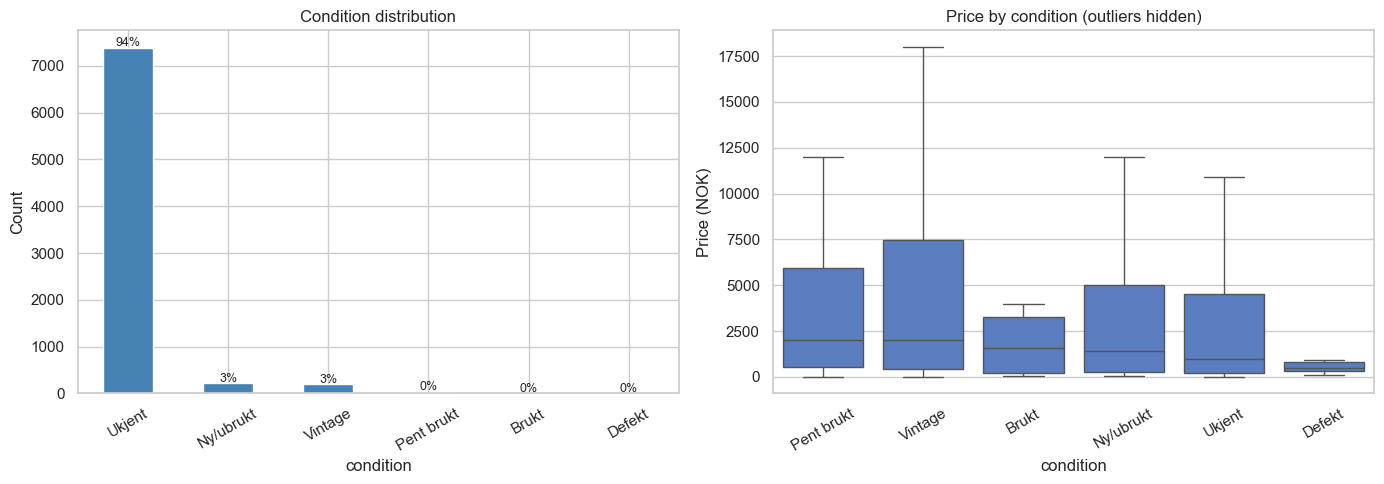

Price by condition:
  Pent brukt       n=   34  median=   2,000 NOK
  Vintage          n=  198  median=   2,000 NOK
  Brukt            n=   11  median=   1,600 NOK
  Ny/ubrukt        n=  222  median=   1,400 NOK
  Ukjent           n=7,387  median=   1,000 NOK
  Defekt           n=   11  median=     500 NOK

→ Condition is detectable for 476 / 7,863 (6.1%) of listings


In [20]:
# ---- 7a. Condition keywords ----
title_lower = model_df["heading"].str.lower()

CONDITION_MAP = {
    "Ny/ubrukt":  r"\b(ny\b|nye\b|ubrukt|uåpnet|sealed|brand\s*new|splitter\s*ny)\b",
    "Pent brukt": r"\b(pent\s*brukt|god\s*stand|lite\s*brukt|velholdt|very\s*good|excellent|mint)\b",
    "Brukt":      r"\b(brukt|used|second.hand)\b",
    "Defekt":     r"\b(defekt|ødelagt|broken|repareres|reparasjon|deler|parts|for\s*parts)\b",
    "Vintage":    r"\b(vintage|retro|antikk|gammel|samleobjekt|collector)\b",
}

def classify_condition(title):
    for cond, pattern in CONDITION_MAP.items():
        if re.search(pattern, title):
            return cond
    return "Ukjent"

import re
model_df["condition"] = title_lower.apply(classify_condition)

cond_counts = model_df["condition"].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cond_counts.plot.bar(ax=axes[0], color="steelblue", edgecolor="white")
axes[0].set_title("Condition distribution")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=30)
for i, (v, cat) in enumerate(zip(cond_counts.values, cond_counts.index)):
    axes[0].text(i, v + 30, f"{v/len(model_df)*100:.0f}%", ha="center", fontsize=9)

order = model_df.groupby("condition")["price_amount"].median().sort_values(ascending=False).index
sns.boxplot(data=model_df, x="condition", y="price_amount", order=order,
            ax=axes[1], showfliers=False)
axes[1].set_title("Price by condition (outliers hidden)")
axes[1].set_ylabel("Price (NOK)")
axes[1].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

print("Price by condition:")
for c in order:
    n = (model_df["condition"] == c).sum()
    med = model_df.loc[model_df["condition"] == c, "price_amount"].median()
    print(f"  {c:<15s}  n={n:>5,}  median={med:>8,.0f} NOK")

print(f"\n→ Condition is detectable for {(model_df['condition'] != 'Ukjent').sum():,} / {len(model_df):,} "
      f"({(model_df['condition'] != 'Ukjent').mean()*100:.1f}%) of listings")

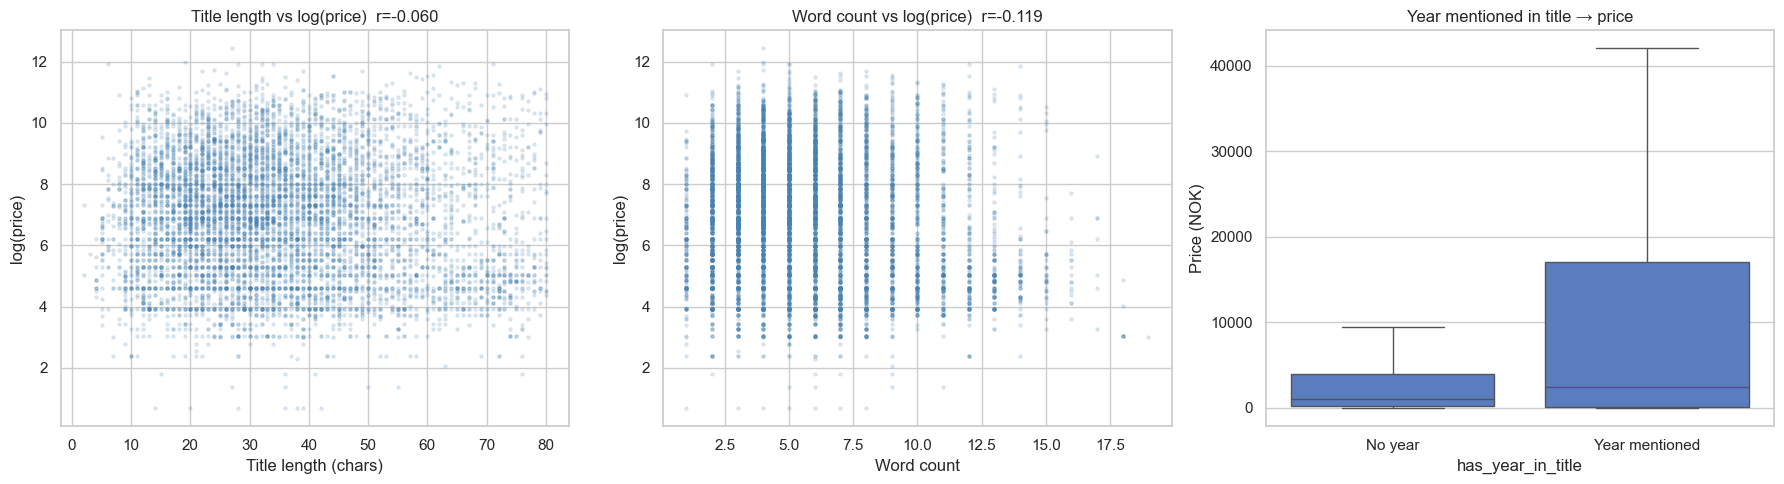

Median price without year: 1,000 NOK
Median price with year:    2,500 NOK
→ Listings mentioning a year have 2.5× higher median price


In [21]:
# ---- 7b. Title-derived numeric features ----
model_df["title_len"] = model_df["heading"].str.len()
model_df["title_word_count"] = model_df["heading"].str.split().str.len()

# Does the title mention a year? (likely vintage/specific model → higher price)
model_df["has_year_in_title"] = model_df["heading"].str.contains(
    r"\b(19[5-9]\d|20[0-2]\d)\b", regex=True, na=False
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Title length vs price
axes[0].scatter(model_df["title_len"], model_df["log_price"], alpha=0.15, s=5, color="steelblue")
axes[0].set_xlabel("Title length (chars)")
axes[0].set_ylabel("log(price)")
axes[0].set_title(f"Title length vs log(price)  r={model_df['title_len'].corr(model_df['log_price']):.3f}")

# Word count vs price
axes[1].scatter(model_df["title_word_count"], model_df["log_price"], alpha=0.15, s=5, color="steelblue")
axes[1].set_xlabel("Word count")
axes[1].set_ylabel("log(price)")
axes[1].set_title(f"Word count vs log(price)  r={model_df['title_word_count'].corr(model_df['log_price']):.3f}")

# Year mentioned → price difference
sns.boxplot(data=model_df, x="has_year_in_title", y="price_amount", ax=axes[2], showfliers=False)
axes[2].set_title("Year mentioned in title → price")
axes[2].set_ylabel("Price (NOK)")
axes[2].set_xticklabels(["No year", "Year mentioned"])

plt.tight_layout()
plt.show()

year_med = model_df.groupby("has_year_in_title")["price_amount"].median()
print(f"Median price without year: {year_med[False]:,.0f} NOK")
print(f"Median price with year:    {year_med[True]:,.0f} NOK")
print(f"→ Listings mentioning a year have {year_med[True]/year_med[False]:.1f}× higher median price")

## 9 — Correlation & Feature Importance

Now that we have engineered features, let's measure which ones are actually predictive of price.

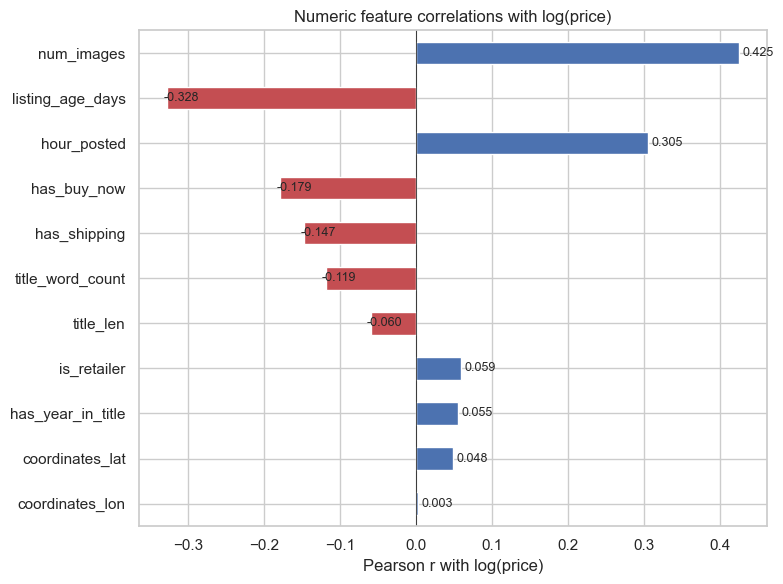

In [22]:
# ---- 9a. Pearson correlation of numeric features with log(price) ----

# Ensure temporal features exist on model_df
model_df["timestamp_dt"] = pd.to_datetime(model_df["timestamp_dt"], utc=True, errors="coerce")
model_df["listing_age_days"] = (pd.Timestamp.now(tz="UTC") - model_df["timestamp_dt"]).dt.days
model_df["hour_posted"] = model_df["timestamp_dt"].dt.hour

numeric_features = [
    "num_images", "is_retailer", "has_shipping", "has_buy_now",
    "coordinates_lat", "coordinates_lon",
    "title_len", "title_word_count", "has_year_in_title",
    "listing_age_days", "hour_posted",
]
numeric_features = [c for c in numeric_features if c in model_df.columns]

corr_with_price = model_df[numeric_features + ["log_price"]].corr()["log_price"].drop("log_price")
corr_with_price = corr_with_price.reindex(corr_with_price.abs().sort_values(ascending=True).index)

fig, ax = plt.subplots(figsize=(8, 6))
colors = ["#c44e52" if v < 0 else "#4c72b0" for v in corr_with_price.values]
corr_with_price.plot.barh(ax=ax, color=colors)
ax.set_xlabel("Pearson r with log(price)")
ax.set_title("Numeric feature correlations with log(price)")
ax.axvline(0, color="black", lw=0.5)
for i, (v, name) in enumerate(zip(corr_with_price.values, corr_with_price.index)):
    ax.text(v + 0.005 * np.sign(v), i, f"{v:.3f}", va="center", fontsize=9)
plt.tight_layout()
plt.show()

## 10 — Categorical Feature Importance (Mutual Information)

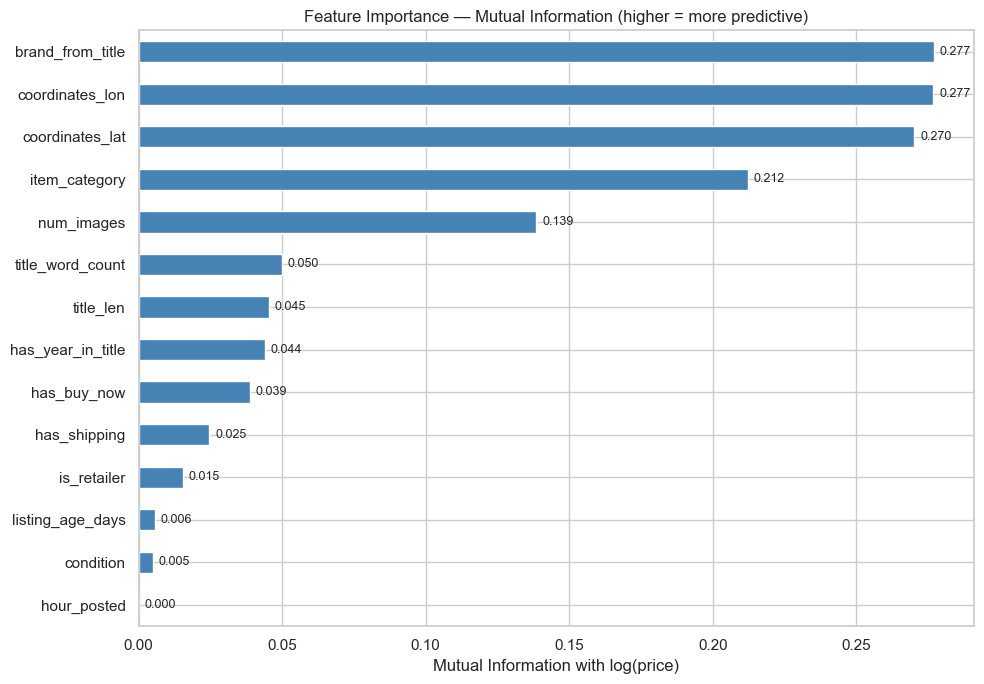

Top features by MI:
  brand_from_title           MI = 0.2772
  coordinates_lon            MI = 0.2768
  coordinates_lat            MI = 0.2702
  item_category              MI = 0.2122
  num_images                 MI = 0.1385
  title_word_count           MI = 0.0499
  title_len                  MI = 0.0453
  has_year_in_title          MI = 0.0441
  has_buy_now                MI = 0.0388
  has_shipping               MI = 0.0247
  is_retailer                MI = 0.0154
  listing_age_days           MI = 0.0056
  condition                  MI = 0.0049
  hour_posted                MI = 0.0000


In [23]:
# ---- Mutual Information for categorical + numeric features ----
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

# Build feature matrix
mi_df = model_df.copy()

# Encode categoricals as integers for MI calculation
cat_features = ["item_category", "brand_from_title", "condition"]
le_dict = {}
for col in cat_features:
    le = LabelEncoder()
    mi_df[col + "_enc"] = le.fit_transform(mi_df[col].fillna("Unknown"))
    le_dict[col] = le

feature_cols = (
    [c + "_enc" for c in cat_features]
    + numeric_features
)

X = mi_df[feature_cols].fillna(0).values
y = mi_df["log_price"].values

# Mark which features are discrete (categoricals + booleans)
discrete_mask = [True] * len(cat_features) + [
    col in ("is_retailer", "has_shipping", "has_buy_now", "has_year_in_title")
    for col in numeric_features
]

mi_scores = mutual_info_regression(X, y, discrete_features=discrete_mask, random_state=42)
mi_series = pd.Series(mi_scores, index=[c.replace("_enc", "") for c in feature_cols])
mi_series = mi_series.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 7))
mi_series.plot.barh(ax=ax, color="steelblue")
ax.set_xlabel("Mutual Information with log(price)")
ax.set_title("Feature Importance — Mutual Information (higher = more predictive)")
for i, (v, name) in enumerate(zip(mi_series.values, mi_series.index)):
    ax.text(v + 0.002, i, f"{v:.3f}", va="center", fontsize=9)
plt.tight_layout()
plt.show()

print("Top features by MI:")
for name, score in mi_series.sort_values(ascending=False).items():
    print(f"  {name:<25s}  MI = {score:.4f}")

## 11 — Summary & Feature Shortlist

In [24]:
# ---- Final feature summary table ----
print("=" * 70)
print("MODELLING RECOMMENDATIONS")
print("=" * 70)
print()
print(f"Target:     log(1 + price_amount)")
print(f"Scope:      trade_type == 'Til salgs' & price > 0  →  {len(model_df):,} rows")
print()
print("FEATURE SHORTLIST (ranked by MI):")
print("-" * 70)
print(f"{'Feature':<25s} {'Type':<12s} {'MI':>6s}  {'Pearson r':>10s}  Notes")
print("-" * 70)

# Combine MI and correlation info
pearson = model_df[numeric_features + ["log_price"]].corr()["log_price"].drop("log_price")

for name, mi_val in mi_series.sort_values(ascending=False).items():
    if name in pearson.index:
        r_val = f"{pearson[name]:+.3f}"
        ftype = "numeric"
    else:
        r_val = "    n/a"
        ftype = "categorical"
    
    notes = ""
    if name == "item_category":
        n_cats = model_df["item_category"].nunique()
        notes = f"{n_cats} categories (dominant separator)"
    elif name == "brand_from_title":
        pct = (model_df["brand_from_title"] != "Unknown").mean() * 100
        notes = f"detected in {pct:.0f}% of titles"
    elif name == "condition":
        pct = (model_df["condition"] != "Ukjent").mean() * 100
        notes = f"detected in {pct:.0f}% of titles"
    elif name == "num_images":
        notes = "proxy for seller effort"
    elif name == "has_year_in_title":
        notes = "vintage/specific model indicator"
    elif name == "is_retailer":
        notes = "retailers price ~2× private"
    elif name == "has_shipping":
        notes = "lower-priced items offer shipping"
    elif name == "coordinates_lat":
        notes = "north/south Norway proxy"
    
    print(f"  {name:<23s} {ftype:<12s} {mi_val:>6.4f}  {r_val:>10s}  {notes}")

print()
print("PREPROCESSING NOTES:")
print("  • Use log(1+price) as target — raw price has skew ~8, log has ~0.2")
print("  • Encode item_category & brand as one-hot or target-encoded")
print("  • condition can be ordinal: Defekt < Brukt < Pent brukt < Ny/ubrukt")
print("  • 'Annet' and 'Unknown' are catch-all bins — consider sub-splitting via NLP")
print("  • ~50% of titles have no detected condition → model should handle missing")

MODELLING RECOMMENDATIONS

Target:     log(1 + price_amount)
Scope:      trade_type == 'Til salgs' & price > 0  →  7,863 rows

FEATURE SHORTLIST (ranked by MI):
----------------------------------------------------------------------
Feature                   Type             MI   Pearson r  Notes
----------------------------------------------------------------------
  brand_from_title        categorical  0.2772         n/a  detected in 31% of titles
  coordinates_lon         numeric      0.2768      +0.003  
  coordinates_lat         numeric      0.2702      +0.048  north/south Norway proxy
  item_category           categorical  0.2122         n/a  11 categories (dominant separator)
  num_images              numeric      0.1385      +0.425  proxy for seller effort
  title_word_count        numeric      0.0499      -0.119  
  title_len               numeric      0.0453      -0.060  
  has_year_in_title       numeric      0.0441      +0.055  vintage/specific model indicator
  has_buy_now 